In [105]:
import numpy as np
from scipy.sparse.linalg import LinearOperator, svds
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from scipy.signal import convolve2d
from pathlib import Path

In [106]:
figdir = Path('figures')
if not figdir.exists():
    figdir = Path('.')

Le code pour les ondelettes est fourni

In [107]:
# Ondelettes 1D, une étape
def encode1d(x):
    c = 0.5**0.5
    x_len = x.size
    y = np.empty_like(x)
    y[:x_len//2] = convolve1d(x, [c, c], mode='wrap')[::2]
    y[x_len//2:] = convolve1d(x, [-c, c], mode='wrap')[::2]
    return y

def decode1d(y):
    c = 0.5**0.5
    y_len = y.size
    x = np.empty_like(y)
    y1, y2 = y[:y_len//2], y[y_len//2:]
    x[::2] = y1 + y2
    x[1::2] = y1 - y2
    return x * c

# Ondelettes 2D, une étape
def encode2d(x_mat):
    y_mat = x_mat.copy()
    for i in range(y_mat.shape[0]):
        y_mat[i, :] = encode1d(y_mat[i, :])
    for j in range(y_mat.shape[1]):
        y_mat[:, j] = encode1d(y_mat[:, j])
    return y_mat

def decode2d(y_mat):
    x_mat = y_mat.copy()
    for i in range(x_mat.shape[0]):
        x_mat[i, :] = decode1d(x_mat[i, :])
    for j in range(x_mat.shape[1]):
        x_mat[:, j] = decode1d(x_mat[:, j])
    return x_mat

# Ondelettes 2D, plusieurs étapes
def encode2d_k(x_mat, k=None):
    if k is None:
        k = int(np.min(np.log2(x_mat.shape)))
    y_mat = x_mat.copy()
    n_rows, n_cols = y_mat.shape
    for p in range(k):
        y_mat[:n_rows, :n_cols] = encode2d(y_mat[:n_rows, :n_cols])
        n_rows, n_cols = n_rows//2, n_cols//2
    return y_mat

def decode2d_k(y_mat, k=None):
    if k is None:
        k = int(np.min(np.log2(y_mat.shape)))
    if k is None:
        k = int(np.log2(y.size))
    x_shape = np.array(y_mat.shape) // 2 ** (k-1)
    x_mat = y_mat.copy()
    for _ in range(k):
        x_mat[:x_shape[0],:x_shape[1]] = decode2d(x_mat[:x_shape[0],:x_shape[1]])
        x_shape *= 2
    return x_mat

**Question:** compléter le code de l'opérateur d'ondelettes 2D en utilisant les fonctions `encode2d_k` et `decode2d_k`.

In [108]:
class Ondelettes2D(LinearOperator):
    def __init__(self, image_shape, dtype=float):
        linop_shape = (np.prod(image_shape), ) * 2
        LinearOperator.__init__(self, dtype=dtype, shape=linop_shape)
        self.image_shape = image_shape
    
    def _matvec(self, x):
        """ Opérateur direct: décode une représentation `x` vectorisée pour obtenir une image vectorisée
        """
        return decode2d_k(x.reshape(self.image_shape)).ravel()
    
    def _rmatvec(self, y):
        """ Opérateur adjoint: encode une image vectorisée `y` pour obtenir un vecteur de représentation
        """
        return encode2d_k(y.reshape(self.image_shape)).ravel()
    
    def apply_2d(self, x):
        """ Décode une représentation matricielle `x` pour obtenir une image sous forme matricielle
        """
        y = self @ x.ravel()
        return y.reshape(self.image_shape)
    
    def apply_adjoint_2d(self, y):
        """ Encode une image sous forme matricielle `y` pour obtenir une représentation matricielle
        """
        x = self.T @ y.ravel()
        return x.reshape(self.image_shape)


In [109]:
# Vérification de la propriété de l'adjoint <A x, y> = <x, A.T y> pour tout x, y.
image_shape = (16, 16)
A = Ondelettes2D(image_shape=image_shape)
n = np.prod(image_shape)
for _ in range(10):
    x = np.random.randn(n)
    y = np.random.randn(n)
    print(np.vdot(A@x, y)-np.vdot(x, A.T@y))

0.0
-6.217248937900877e-15
7.105427357601002e-15
5.329070518200751e-15
-1.7763568394002505e-15
0.0
-3.552713678800501e-15
7.105427357601002e-15
3.552713678800501e-15
-7.993605777301127e-15


Image 128x128


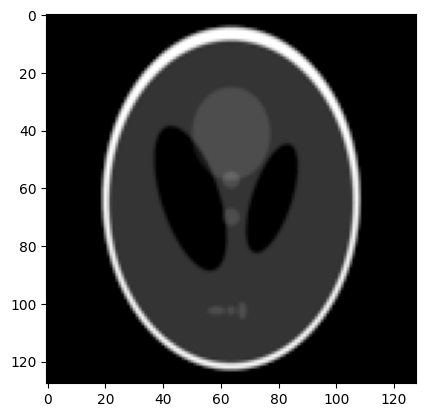

In [110]:
image = plt.imread(figdir / 'SheppLogan_Phantom_128.png')

plt.imshow(image, cmap='gray')
print(f'Image {image.shape[0]}x{image.shape[1]}')

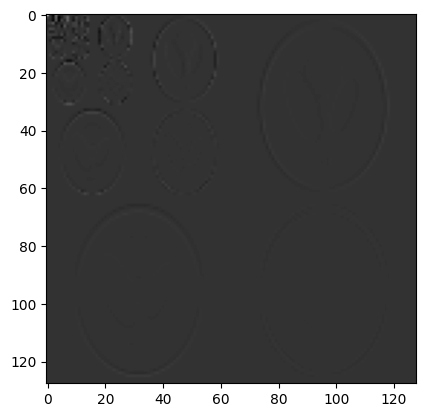

In [111]:
A = Ondelettes2D(image_shape=image.shape)
y = A.apply_adjoint_2d(image)
plt.imshow(y, cmap='gray')
plt.savefig(figdir / 'ondelettes_phantom.png')

Résolution: on fournit le code d'ISTA

In [112]:
def compute_snr(x_true, x_noisy):
    return 20 * np.log10(np.linalg.norm(x_true) / np.linalg.norm(x_true - x_noisy))


def soft_thresholding(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0)


def add_noise(x, snr):
    noise = np.random.randn(x.size)
    return x + 10 ** (-snr / 20) * np.linalg.norm(x) / np.linalg.norm(noise) * noise


def ista_l1(A, y, x0, alpha, n_iterations):
    x = x0
    x_list = [x]
    step_size = 0.5 / svds(A, k=1, return_singular_vectors=False)[0] ** 2
    for i in range(n_iterations):
        u = x - 2 * step_size * A.T @ (A @ x - y)
        x = soft_thresholding(u, step_size * alpha)
        x_list.append(x)
    return x, x_list


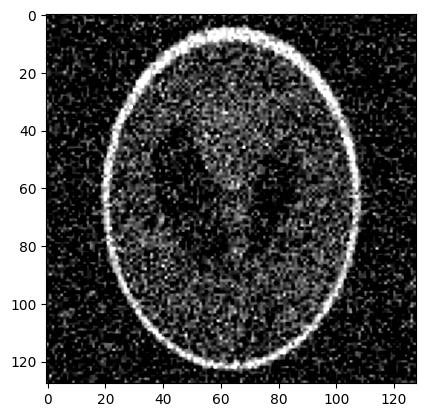

In [113]:
y = add_noise(image.ravel(), snr=0)
plt.imshow(y.reshape(image.shape), cmap='gray', vmin=0, vmax=1)

SNR for y: 1.928654933106574e-15dB
SNR for x: 0.13318865992083948dB


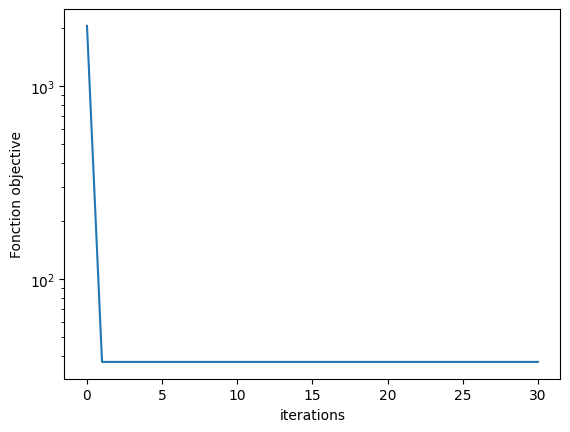

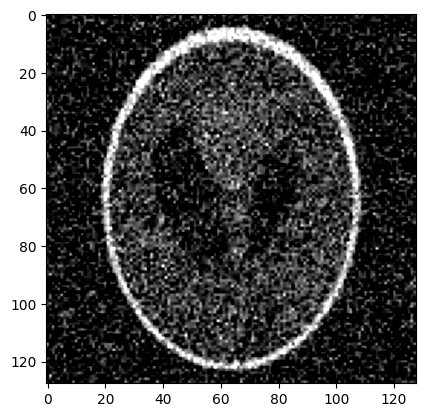

In [114]:
alpha = 1e-2
n_iterations = 30
x0 = np.zeros(A.shape[1])
x_est, x_list = ista_l1(A=A, y=y, x0=x0, alpha=alpha, n_iterations=n_iterations)

plt.figure()
plt.semilogy([np.linalg.norm(A@x-y) ** 2 + alpha * np.linalg.norm(x, ord=1) for x in x_list])
plt.xlabel('iterations')
plt.ylabel('Fonction objective')

plt.figure()
plt.imshow((A@x_est).reshape(image.shape), cmap='gray', vmin=0, vmax=1)
print(f'SNR for y: {compute_snr(x_true=image.ravel(), x_noisy=y)}dB')
print(f'SNR for x: {compute_snr(x_true=image.ravel(), x_noisy=A@x_est)}dB')


**Question:** testez plusieurs valeurs pour le paramètre de régularisation `alpha`, calculez le SNR pour chaque valeur.

alpha: 0.0001, SNR: 0.0013293616437812358dB
alpha: 0.001, SNR: 0.013295040797806707dB
alpha: 0.01, SNR: 0.13318865992083948dB
alpha: 0.1, SNR: 1.3530846977437059dB
alpha: 0.5, SNR: 6.4689605852639644dB
alpha: 1, SNR: 7.634442293132528dB
alpha: 1.5, SNR: 6.00100141225435dB
alpha: 2, SNR: 4.749591216505656dB
alpha: 5, SNR: 2.1050304779141054dB
alpha: 10, SNR: 1.3347141287995468dB
alpha: 100, SNR: -3.795302679395477e-06dB
alpha: 1000, SNR: -3.795302679395477e-06dB


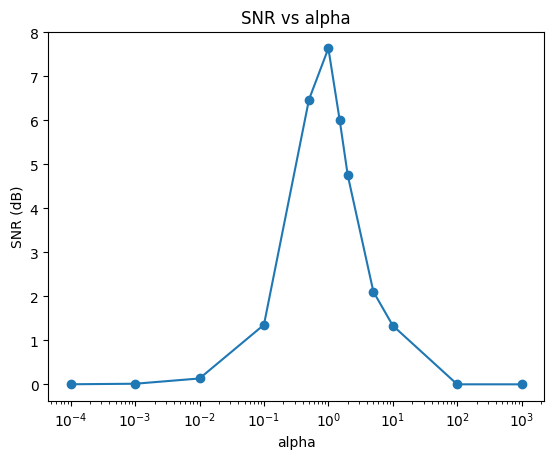

In [115]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1,1.5,2,5, 10, 100, 1000]
snrs = []

for alpha in alphas:
    x_est, _ = ista_l1(A=A, y=y, x0=np.zeros(A.shape[1]), alpha=alpha, n_iterations=30)
    snr = compute_snr(x_true=image.ravel(), x_noisy=A@x_est)
    snrs.append(snr)
    print(f'alpha: {alpha}, SNR: {snr}dB')

plt.figure()
plt.plot(alphas, snrs, marker='o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('SNR (dB)')
plt.title('SNR vs alpha')
plt.savefig(figdir / 'snr_vs_alpha.png')

**Question:** affichez le SNR en fonction de `alpha` et sélectionnez le paramètre permettant d'atteinde la valeur maximale.

In [116]:
best_alpha = alphas[np.argmax(snrs)]
print(f'Best alpha: {best_alpha}, SNR: {max(snrs)}dB')
plt.show()



Best alpha: 1, SNR: 7.634442293132528dB


**Question:** avec la valeur de `alpha` sélectionnée, résolvez à nouveau le problème, calculez le SNR affichez l'image obtenue.

SNR for x with best alpha: 7.634442293132528dB


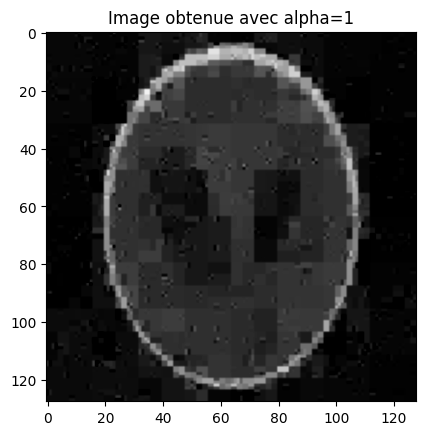

In [117]:
# Use the best alpha value
alpha = best_alpha

# Solve the problem again using ISTA
x_est, x_list = ista_l1(A=A, y=y, x0=np.zeros(A.shape[1]), alpha=alpha, n_iterations=n_iterations)

# Calculate the SNR
snr = compute_snr(x_true=image.ravel(), x_noisy=A_ondelettes @ x_est)
print(f'SNR for x with best alpha: {snr}dB')

# Display the obtained image
plt.figure()
plt.imshow((A_ondelettes @ x_est).reshape(image.shape), cmap='gray', vmin=0, vmax=1)
plt.title(f'Image obtenue avec alpha={alpha}')
plt.show()

# Inpainting

**Question:** codez l'opérateur de masquage, générez et résolvez un problème d'inpainting.

In [118]:
class InpaintingOperator(LinearOperator):
    def __init__(self, mask, dtype=float):
        linop_shape = (np.count_nonzero(mask), np.prod(mask.shape))
        LinearOperator.__init__(self, dtype=dtype, shape=linop_shape)
        self.mask = mask
    
    def _matvec(self, x):
        """ Opérateur direct: masque une image `x` vectorisée pour obtenir le vecteur des pixels observés (c'est-à-dire non masqués)
        """
        return x[self.mask.ravel()]
    
    def _rmatvec(self, y):
        """ Opérateur adjoint: reconstruit une image vectorisée `y` à partir d'un sous ensemble de pixels observés, avec des zéros au niveau des pixels masqués
        """
        x = np.zeros(self.shape[1])
        x[self.mask.ravel()] = y
        return x
    
    def apply_2d(self, x):
        """ Masque une image `x` (sous forme matricielle) pour obtenir le vecteur des pixels observés
        """
        y = self @ x.ravel()
        return y
    
    def apply_adjoint_2d(self, y):
        """ Reconstruit une image `y` à partir d'un sous ensemble de pixels observés, avec des zéros au niveau des pixels masqués
        """
        x = self.T @ y.ravel()
        return x.reshape(self.mask.shape)

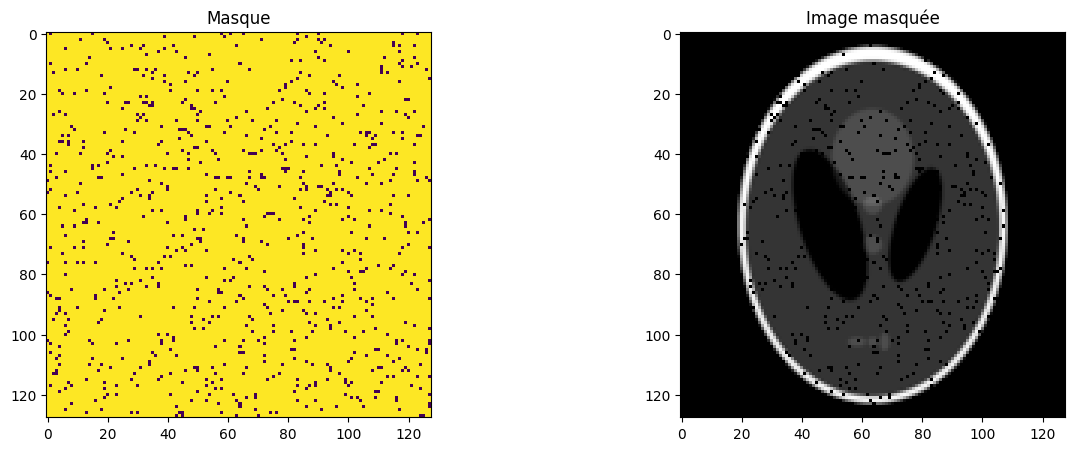

In [119]:
missing_ratio = 0.05  # Proportion de données manquantes
n_mask = int(missing_ratio* image.size)
ind_mask = np.random.choice(image.size, size=n_mask, replace=False)
mask = np.ones_like(image, dtype=bool)
mask.flat[ind_mask] = False
y = image.copy()
y[~mask] = 0

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(mask)
axes[0].set_title('Masque')
axes[1].imshow(y, cmap='gray')
axes[1].set_title('Image masquée')
plt.savefig(figdir / 'inpainting_masque.png')

(15565, 16384) (16384,)


Text(0.5, 1.0, 'Image masquée')

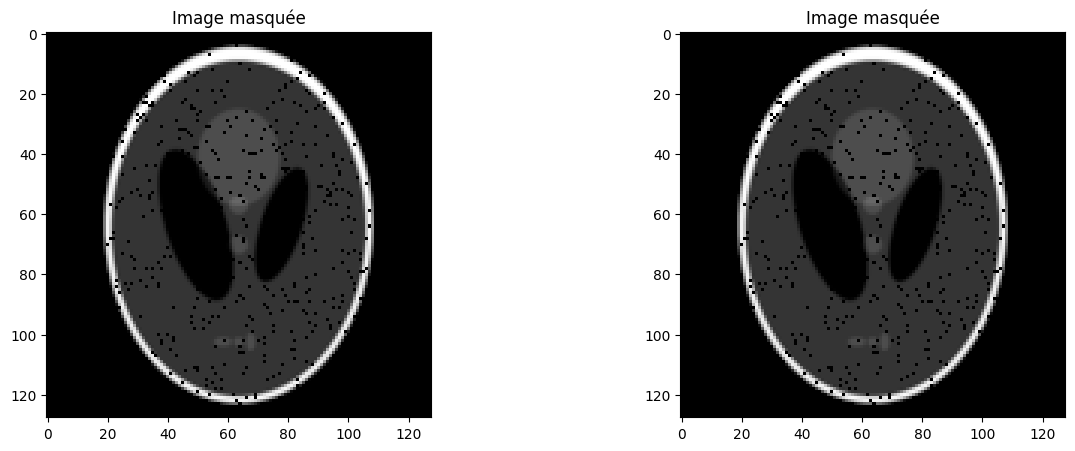

In [120]:
A_inpainting = InpaintingOperator(mask=mask)
print(A_inpainting.shape, image.ravel().shape)
y = A_inpainting @ image.ravel()
z = A_inpainting.T @ y
z = z.reshape(image.shape)
zz = A_inpainting.apply_adjoint_2d(A_inpainting.apply_2d(image))
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(z, cmap='gray')
axes[0].set_title('Image masquée')
axes[1].imshow(zz, cmap='gray')
axes[1].set_title('Image masquée')


In [128]:
class InpaintingOperator(LinearOperator):
    def __init__(self, mask, dtype=float):
        linop_shape = (np.count_nonzero(mask), np.prod(mask.shape))
        LinearOperator.__init__(self, dtype=dtype, shape=linop_shape)
        self.mask = mask
    
    def _matvec(self, x):
        """ Opérateur direct: masque une image `x` vectorisée pour obtenir le vecteur des pixels observés (c'est-à-dire non masqués)
        """
        return x[self.mask.ravel()]
    
    def _rmatvec(self, y):
        """ Opérateur adjoint: reconstruit une image vectorisée `y` à partir d'un sous ensemble de pixels observés, avec des zéros au niveau des pixels masqués
        """
        x = np.zeros(self.shape[1])
        x[self.mask.ravel()] = y
        return x
    
    def apply_2d(self, x):
        """ Masque une image `x` (sous forme matricielle) pour obtenir le vecteur des pixels observés
        """
        y = self @ x.ravel()
        return y
    
    def apply_adjoint_2d(self, y):
        """ Reconstruit une image `y` à partir d'un sous ensemble de pixels observés, avec des zéros au niveau des pixels masqués
        """
        x = self.T @ y.ravel()
        return x.reshape(self.mask.shape)
    

    def mask_to_1d(self):
        """ Transforme le masque en un vecteur 1D
        """
        return self.mask.ravel()

In [131]:
A_ondelettes = Ondelettes2D(image_shape=image.shape)
A = A_inpainting @ A_ondelettes

alpha = 1e-2
n_iterations = 30
x0 = np.zeros(A.shape[1])
x_est, x_list = ista_l1(A=A, y=y, x0=x0, alpha=alpha, n_iterations=n_iterations)

plt.figure()
plt.semilogy([np.linalg.norm(A@x-y) ** 2 + alpha * np.linalg.norm(x, ord=1) for x in x_list])
plt.xlabel('iterations')
plt.ylabel('Fonction objective')

plt.figure()
plt.imshow((A_ondelettes@x_est).reshape(image.shape), cmap='gray', vmin=0, vmax=1)
print(f'SNR for y: {compute_snr(x_true=image.ravel(), x_noisy=A_inpainting.T@y)}dB')
print(f'SNR for x: {compute_snr(x_true=image.ravel(), x_noisy=(A_ondelettes@x_est).reshape(image.shape))}dB')


TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

**Question:** testez plusieurs valeurs pour le paramètre de régularisation `alpha`, calculez le SNR pour chaque valeur.

In [ ]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
snrs = []

for alpha in alphas:
    x_est, _ = ista_l1(A=A, y=y, x0=np.zeros(A.shape[1]), alpha=alpha, n_iterations=30)
    snr = compute_snr(x_true=image.ravel(), x_noisy=A_ondelettes @ x_est)
    snrs.append(snr)
    print(f'alpha: {alpha}, SNR: {snr}dB')


TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

**Question:** affichez le SNR en fonction de `alpha` et sélectionnez le paramètre permettant d'atteinde la valeur maximale.

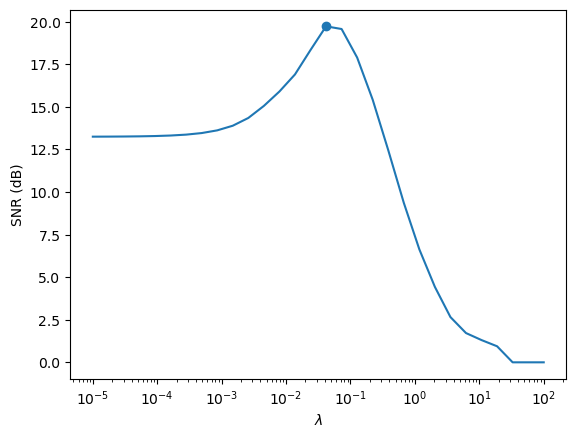

In [19]:
# TODO


**Question:** avec la valeur de `alpha` sélectionnée, résolvez à nouveau le problème, calculez le SNR affichez l'image obtenue.

SNR for y: 13.24101475012186dB
SNR for x: 19.722209420373936dB


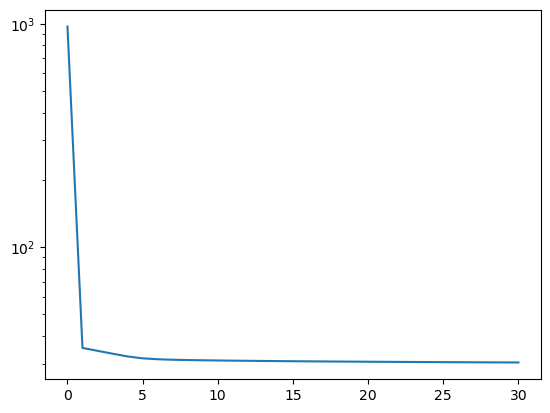

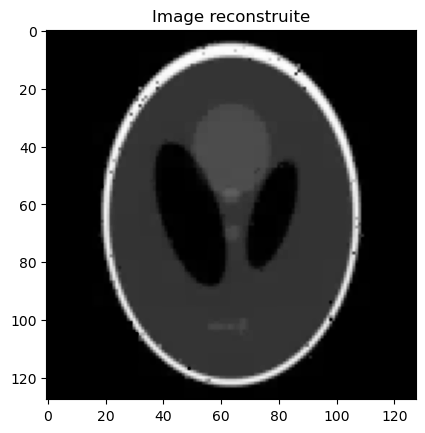

In [20]:
# TODO
